## Data Pre-Processing

In [ ]:
import pandas as pd

data = pd.read_csv('forBayesNet_1.csv')

# Convert to DataFrame
df = pd.DataFrame(data)

# Create a mapping for the positions
position_mapping = {
    'Position_C': 1,
    'Position_PF': 2,
    'Position_PG': 3,
    'Position_SF': 4,
    'Position_SG': 5
}

# Create a new column for Position
def map_position(row):
    for pos_col, pos_value in position_mapping.items():
        if row[pos_col] == 1:
            return pos_value
    return 0  # Return 0 if no position matches (could represent 'No Position')

# Apply the mapping
df['Position'] = df.apply(map_position, axis=1)

# Drop original one-hot encoded columns
df.drop(columns=['Position_C', 'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG'], inplace=True)

# Save the updated DataFrame to a new CSV file
df.to_csv('bayes', index=False)

# Display the updated DataFrame
print("New CSV file 'bayes.csv' created with the consolidated position column.")
# print(df)


In [ ]:
import pandas as pd
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork

# Load the data
data = pd.read_csv('bayes.csv')

# Define the list of continuous columns to bin into quartiles
continuous_columns = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 
                      'eFG%', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 
                      'TOV', 'PF', 'PTS', 'PER', 'poss']

# Function to bin column values into quartiles (0, 1, 2, 3)
def encode_quartiles(column):
    q1 = column.quantile(0.25)
    q2 = column.quantile(0.5)
    q3 = column.quantile(0.75)
    
    return pd.cut(column, bins=[-float('inf'), q1, q2, q3, float('inf')], labels=[0, 1, 2, 3])

# Apply encoding to each continuous column
for col in continuous_columns:
    data[col] = encode_quartiles(data[col])

# Save the transformed data to a new CSV file
data.to_csv('BayesNet_transformed1.csv', index=False)
print("Transformed data saved to 'BayesNet_transformed1.csv'.")

## Creation of Bayesian Network

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Structure (Edges): [('FG', 'PTS'), ('FG', '2PA'), ('FG', 'GS'), ('FGA', 'FG'), ('FGA', 'poss'), ('3P', 'eFG%'), ('3PA', '3P'), ('3PA', 'Position'), ('2P', 'TRB'), ('2P', 'PER'), ('2PA', '2P'), ('eFG%', 'PER'), ('FT', '2PA'), ('ORB', 'BLK'), ('ORB', '3PA'), ('ORB', 'Position'), ('DRB', 'PF'), ('DRB', 'BLK'), ('TRB', 'DRB'), ('TRB', 'ORB'), ('STL', 'PF'), ('TOV', 'AST'), ('PF', 'TOV'), ('PTS', 'FT'), ('poss', 'TOV'), ('poss', 'STL'), ('poss', '3PA'), ('poss', 'PTS'), ('poss', 'ORB'), ('poss', 'DRB'), ('Position', 'AST')]
BIC Score of the Learned Model: -45359.37495812909


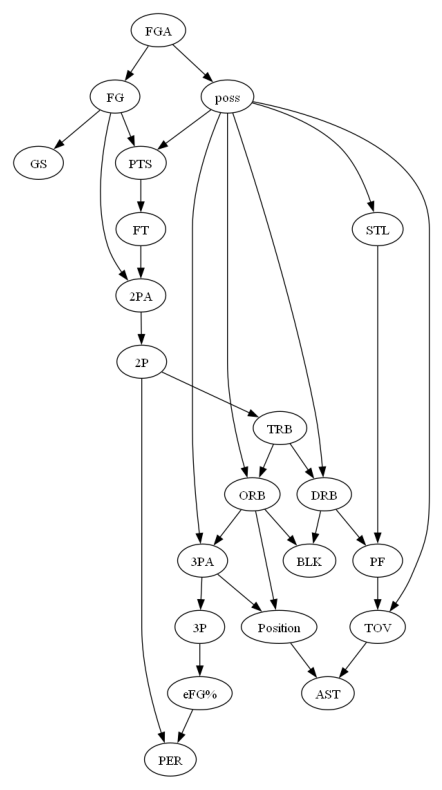

In [19]:
import pandas as pd
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
import graphviz
import matplotlib.pyplot as plt

# Load the transformed data
data_transformed = pd.read_csv('BayesNet_transformed1.csv')

# Define the features to use
features_to_use = [
    'GS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA',
    'eFG%', 'FT', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
    'BLK', 'TOV', 'PF', 'PTS', 'PER', 'poss','Position'
]

# Create a new DataFrame with selected features
selected_data = data_transformed[features_to_use]

# Initialize HillClimbSearch with the selected features
hc = HillClimbSearch(selected_data)

# Define fixed edges based on domain knowledge
fixed_edges = [('3PA', '3P'), ('FGA', 'FG')]

# Estimate the best model structure with fixed edges
best_model = hc.estimate(scoring_method=BicScore(selected_data), fixed_edges=fixed_edges)

# Create the Bayesian Network model from the estimated structure
bayes_net = BayesianNetwork(best_model.edges())

# Print the edges in the learned Bayesian Network
print("Learned Structure (Edges):", best_model.edges())

# Calculate the BIC score of the learned model
bic_score = BicScore(selected_data).score(best_model)
print("BIC Score of the Learned Model:", bic_score)

# Visualize the learned Bayesian Network
dot = graphviz.Digraph()

# Add nodes to the graph
for node in bayes_net.nodes():
    dot.node(node)

# Add edges to the graph
for edge in bayes_net.edges():
    dot.edge(edge[0], edge[1])

# Render the graph and save it as a PNG file
dot.render('bayesian_network', format='png', cleanup=True)

# Display the PNG file using matplotlib
img = plt.imread('bayesian_network.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


## Inferecing of Postion using Variable Elimination

In [20]:
import pandas as pd
from pgmpy.estimators import ExpectationMaximization
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
import numpy as np

data_transformed = pd.read_csv('BayesNet_transformed1.csv')

# Define the features to use
features_to_use = [
    'GS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA',
    'eFG%', 'FT', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
    'BLK', 'TOV', 'PF', 'PTS', 'PER', 'poss','Position'
]

# Split the data into train and test sets
train_data, test_data = train_test_split(data_transformed[features_to_use], test_size=0.1, random_state=42)

# Train the Bayesian Network on the training data
bayes_net.fit(train_data, estimator=ExpectationMaximization)

# Initialize inference for the trained model
inference = VariableElimination(bayes_net)

# Function to validate evidence based on model state names
def validate_evidence(evidence):
    valid_evidence = {}
    for var, val in evidence.items():
        try:
            # Retrieve valid states for each variable in the Bayesian Network model
            valid_states = bayes_net.get_cpds(var).state_names[var]
            if val in valid_states:
                valid_evidence[var] = val
            else:
                print(f"Invalid state {val} for {var}; skipping this evidence.")
        except KeyError:
            print(f"{var} has no states defined in the model; skipping.")
    return valid_evidence

# Function to predict Position based on validated feature evidence
def predict_position(evidence):
    valid_evidence = validate_evidence(evidence)
    try:
        # Query with validated evidence
        position_query = inference.query(variables=['Position'], evidence=valid_evidence)
        probabilities = position_query.values.flatten()
        most_likely_position_index = np.argmax(probabilities)
        return position_query.state_names['Position'][most_likely_position_index]
    except Exception as e:
        print("Error in prediction:", e)
        return None

# Test the model on the test data and calculate accuracy
correct_predictions = 0
total_predictions = 0

for _, row in test_data.iterrows():
    # Extract evidence by selecting only the columns used in the Bayesian Network
    evidence = row.drop('Position').to_dict()
    
    # Predict the Position
    predicted_position = predict_position(evidence)
    
    # Check if a valid prediction was made
    if predicted_position is not None:
        total_predictions += 1
        # Compare with actual Position
        if predicted_position == row['Position']:
            correct_predictions += 1

# Calculate accuracy with a check for valid predictions
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Accuracy of Position prediction: {accuracy:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of Position prediction: 0.5409


In [22]:
from pgmpy.inference import VariableElimination
import numpy as np

# Create an inference object
inference = VariableElimination(bayes_net)

# Example player feature values (replace with actual values)
player_features = {
    'GS': 3, 'FG': 3, 'FGA': 3, '3P': 3, '3PA': 2,
    '2P': 3, '2PA': 3, 'eFG%': 2, 'FT': 3, 'ORB': 2,
    'DRB': 3, 'TRB': 3, 'AST': 3, 'STL': 3, 'BLK': 3,
    'TOV': 3, 'PF': 3, 'PTS': 2, 'PER': 3, 'poss': 3
}

# Query the network for the position probabilities
position_query = inference.query(
    variables=['Position'],
    evidence=player_features
)

print("Position Probability Distribution:")
# Get the state names for the position variable
states = position_query.state_names['Position']
probabilities = position_query.values.flatten()  # Flatten the array to 1D

for state_index, state in enumerate(states):
    # Convert numpy float to Python float for proper formatting
    prob = float(probabilities[state_index])
    print(f"  Position {state}: {prob:.4f}")

# Optional: Get the most likely position
most_likely_position_index = np.argmax(position_query.values)
most_likely_position = states[most_likely_position_index]
most_likely_prob = float(np.max(position_query.values))
print(f"\nMost likely position: {most_likely_position} with probability {most_likely_prob:.4f}")


Position Probability Distribution:
  Position 1: 0.0379
  Position 2: 0.2066
  Position 3: 0.1638
  Position 4: 0.4140
  Position 5: 0.1777

Most likely position: 4 with probability 0.4140


## Clustering of Players using Bayesian Network

In [23]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
import networkx as nx
# from community import community_louvain
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
# from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import plotly.express as px
# import plotly.graph_objects as go
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

class OptimizedBayesNetClustering:
    def __init__(self, bayes_net, n_clusters=9, batch_size=500):
        self.bayes_net = bayes_net
        self.n_clusters = n_clusters
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        
    def create_similarity_matrix(self, data):
        """Create an optimized similarity matrix using batching and sparse matrices"""
        print("Creating optimized similarity matrix...")
        
        # Pre-compute network structure information
        edges = list(self.bayes_net.edges())
        node_list = list(self.bayes_net.nodes())
        node_indices = {node: idx for idx, node in enumerate(node_list)}
        
        # Initialize sparse matrix for features
        n_samples = len(data)
        n_features = len(node_list) + len(edges)
        feature_matrix = np.zeros((n_samples, n_features))
        
        # Process data in batches
        for i in tqdm(range(0, n_samples, self.batch_size)):
            batch_end = min(i + self.batch_size, n_samples)
            batch_data = data.iloc[i:batch_end]
            
            # Add node values
            for node in node_list:
                node_idx = node_indices[node]
                feature_matrix[i:batch_end, node_idx] = batch_data[node].values
            
            # Add parent-child relationships
            edge_offset = len(node_list)
            for edge_idx, (parent, child) in enumerate(edges):
                feature_matrix[i:batch_end, edge_offset + edge_idx] = (
                    batch_data[parent].values * batch_data[child].values
                )
        
        # Calculate similarities using optimized distance computation
        print("Computing pairwise distances...")
        distances = pdist(feature_matrix, metric='euclidean')
        similarity_matrix = squareform(1 / (1 + distances))
        
        print("Similarity matrix created.")
        return similarity_matrix
    
    def fit(self, data):
        """Fit the clustering model with optimized memory usage"""
        print("Fitting clustering model...")
        
        # Scale the data efficiently
        scaled_data = pd.DataFrame(
            self.scaler.fit_transform(data),
            columns=data.columns
        )
        
        # Get similarity matrix
        similarity_matrix = self.create_similarity_matrix(scaled_data)
        
        print("Using Gaussian Mixture Model clustering...")
        gmm = GaussianMixture(
            n_components=self.n_clusters,
            covariance_type='full',
            random_state=42,
            n_init=5
        )
        
        # Use batching for prediction if memory is constrained
        if len(data) > 10000:
            self.cluster_labels_ = np.zeros(len(data), dtype=int)
            for i in range(0, len(data), self.batch_size):
                batch_end = min(i + self.batch_size, len(data))
                batch_sim = similarity_matrix[i:batch_end]
                self.cluster_labels_[i:batch_end] = gmm.fit_predict(batch_sim)
        else:
            self.cluster_labels_ = gmm.fit_predict(similarity_matrix)
        
        print("Clustering model fitted.")
        return self
    
    def analyze_clusters(self, data):
        """Analyze clusters with efficient memory usage and add descriptive labels"""
        print("Analyzing clusters...")
        cluster_stats = []

        # Define cluster labels based on descriptive analysis of features (example labels)
        cluster_labels = [
            "High Scorers", "Defensive Specialists", "3-Point Shooters",
            "Playmakers", "Rebounders", "Efficient Shooters",
            "Low Turnovers", "Aggressive Defenders", "All-Rounders"
        ]

        for cluster in range(self.n_clusters):
            # Process cluster analysis in batches
            cluster_mask = self.cluster_labels_ == cluster
            cluster_data = data[cluster_mask]

            stats = {
                'Cluster': cluster,
                'Label': cluster_labels[cluster],  # Assign a descriptive label
                'Size': len(cluster_data),
                'Mean_Values': {},
                'Std_Values': {},
                'Key_Features': {}
            }

            # Calculate statistics in batches
            for col in data.columns:
                stats['Mean_Values'][col] = cluster_data[col].mean()
                stats['Std_Values'][col] = cluster_data[col].std()

            # Identify key features
            z_scores = (cluster_data - cluster_data.mean()) / cluster_data.std()
            key_features = z_scores.abs().mean().nlargest(5)
            stats['Key_Features'] = key_features.to_dict()

            cluster_stats.append(stats)

        print("Cluster analysis completed with labels.")
        return cluster_stats
    

    def evaluate_clustering(self, data):
        """Evaluate clustering quality using multiple metrics, including F1 score for LDA."""
        print("Evaluating clustering quality...")
        
        # Scale the data
        scaled_data = self.scaler.transform(data)
        
        # Calculate internal validation metrics
        metrics = {
            'silhouette': silhouette_score(scaled_data, self.cluster_labels_),
            'calinski_harabasz': calinski_harabasz_score(scaled_data, self.cluster_labels_),
            'davies_bouldin': davies_bouldin_score(scaled_data, self.cluster_labels_)
        }
        
        # Perform LDA for classification accuracy and F1 score
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_data, self.cluster_labels_, test_size=0.2, random_state=42
        )
        
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)
        
        # Calculate accuracy and F1 score
        metrics['lda_accuracy'] = lda.score(X_test, y_test)
        metrics['lda_f1_score'] = f1_score(y_test, y_pred, average='weighted')
        
        # Calculate cluster stability
        stability_score = self._calculate_cluster_stability(data)
        metrics['stability_score'] = stability_score
        
        return metrics

    
    def _calculate_cluster_stability(self, data, n_iterations=5):
        """Calculate cluster stability through multiple iterations"""
        stability_scores = []
        base_labels = self.cluster_labels_
        
        for _ in range(n_iterations):
            # Subsample data
            indices = np.random.choice(len(data), size=int(0.8 * len(data)), replace=False)
            subsample = data.iloc[indices]
            
            # Fit a new GMM
            gmm = GaussianMixture(
                n_components=self.n_clusters,
                covariance_type='full',
                random_state=np.random.randint(0, 1000),
                n_init=5
            )
            
            # Create similarity matrix for subsample
            similarity_matrix = self.create_similarity_matrix(subsample)
            new_labels = gmm.fit_predict(similarity_matrix)
            
            # Compare with base clustering (for overlapping points)
            stability_scores.append(
                silhouette_score(self.scaler.transform(subsample), new_labels)
            )
        
        return np.mean(stability_scores)
    
    def visualize_clusters_3d(self, data, method='pca', interactive=True):
        """
        Visualize clusters in 3D using either PCA or LDA
        """
        print(f"Creating 3D visualization using {method.upper()}...")
        
        scaled_data = self.scaler.transform(data)
        
        if method.lower() == 'pca':
            reducer = PCA(n_components=3)
            data_3d = reducer.fit_transform(scaled_data)
            explained_var = reducer.explained_variance_ratio_
            method_name = 'PCA'
        else:  # LDA
            reducer = LinearDiscriminantAnalysis(n_components=3)
            data_3d = reducer.fit_transform(scaled_data, self.cluster_labels_)
            explained_var = None
            method_name = 'LDA'
        
        if interactive:
            # Create interactive 3D plot using plotly
            fig = px.scatter_3d(
                x=data_3d[:, 0],
                y=data_3d[:, 1],
                z=data_3d[:, 2],
                color=self.cluster_labels_,
                title=f'3D Cluster Visualization ({method_name})',
                labels={
                    'x': f'{method_name} Component 1',
                    'y': f'{method_name} Component 2',
                    'z': f'{method_name} Component 3'
                }
            )
            
            if explained_var is not None:
                fig.update_layout(
                    title_text=f'3D Cluster Visualization ({method_name})<br>Explained Variance: ' +
                             f'{explained_var[0]:.2%}, {explained_var[1]:.2%}, {explained_var[2]:.2%}'
                )
            
            fig.show()
        else:
            # Create static matplotlib 3D plot
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            scatter = ax.scatter(
                data_3d[:, 0],
                data_3d[:, 1],
                data_3d[:, 2],
                c=self.cluster_labels_,
                cmap='viridis'
            )
            
            plt.colorbar(scatter)
            ax.set_xlabel(f'{method_name} Component 1')
            ax.set_ylabel(f'{method_name} Component 2')
            ax.set_zlabel(f'{method_name} Component 3')
            
            if explained_var is not None:
                plt.title(f'3D Cluster Visualization ({method_name})\n' +
                         f'Explained Variance: {explained_var[0]:.2%}, {explained_var[1]:.2%}, {explained_var[2]:.2%}')
            else:
                plt.title(f'3D Cluster Visualization ({method_name})')
            
            plt.show()

# Example usage
def main():
    # Use your existing Bayesian network and data
    data_transformed = pd.read_csv('BayesNet_transformed1.csv')
    features_to_use = [
        'GS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA',
        'eFG%', 'FT', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
        'BLK', 'TOV', 'PF', 'PTS', 'PER', 'poss', 'Position'
    ]
    selected_data = data_transformed[features_to_use]
    
    # Initialize HillClimbSearch with the selected features
    hc = HillClimbSearch(selected_data)
    fixed_edges = [('3PA', '3P'), ('FGA', 'FG')]
    best_model = hc.estimate(scoring_method=BicScore(selected_data), fixed_edges=fixed_edges)
    bayes_net = BayesianNetwork(best_model.edges())

    # Create clustering model with 9 clusters
    clustering = OptimizedBayesNetClustering(bayes_net, n_clusters=9)
    clustering.fit(selected_data)
    
    # Analyze clusters
    cluster_analysis = clustering.analyze_clusters(selected_data)
    
    # Evaluate clustering quality
    evaluation_metrics = clustering.evaluate_clustering(selected_data)
    print("\nClustering Quality Metrics:")
    print(f"Silhouette Score: {evaluation_metrics['silhouette']:.3f}")
    print(f"Calinski-Harabasz Score: {evaluation_metrics['calinski_harabasz']:.3f}")
    print(f"Davies-Bouldin Score: {evaluation_metrics['davies_bouldin']:.3f}")
    print(f"LDA Classification Accuracy: {evaluation_metrics['lda_accuracy']:.3f}")
    print(f"Cluster Stability Score: {evaluation_metrics['stability_score']:.3f}")
    
    # Create both PCA and LDA visualizations
    print("\nCreating visualizations...")
    clustering.visualize_clusters_3d(selected_data, method='pca', interactive=True)
    clustering.visualize_clusters_3d(selected_data, method='lda', interactive=True)
    
    return clustering, cluster_analysis, evaluation_metrics

In [24]:
clustering, cluster_analysis, evaluation_metrics = main()

  0%|          | 0/1000000 [00:00<?, ?it/s]

Fitting clustering model...
Creating optimized similarity matrix...


100%|██████████| 6/6 [00:00<00:00, 595.42it/s]

Computing pairwise distances...


Similarity matrix created.
Using Gaussian Mixture Model clustering...
Clustering model fitted.
Analyzing clusters...
Cluster analysis completed with labels.
Evaluating clustering quality...
Creating optimized similarity matrix...


100%|██████████| 5/5 [00:00<00:00, 707.45it/s]

Computing pairwise distances...
Similarity matrix created.


Creating optimized similarity matrix...


100%|██████████| 5/5 [00:00<00:00, 402.64it/s]

Computing pairwise distances...
Similarity matrix created.


Creating optimized similarity matrix...


100%|██████████| 5/5 [00:00<00:00, 766.22it/s]

Computing pairwise distances...
Similarity matrix created.


Creating optimized similarity matrix...


100%|██████████| 5/5 [00:00<00:00, 716.31it/s]

Computing pairwise distances...
Similarity matrix created.


Creating optimized similarity matrix...


100%|██████████| 5/5 [00:00<00:00, 1429.65it/s]

Computing pairwise distances...
Similarity matrix created.



Clustering Quality Metrics:
Silhouette Score: 0.117
Calinski-Harabasz Score: 619.155
Davies-Bouldin Score: 2.128
LDA Classification Accuracy: 0.827
Cluster Stability Score: 0.103

Creating visualizations...
Creating 3D visualization using PCA...


Creating 3D visualization using LDA...


In [26]:
# Evaluate clustering quality
# evaluation_metrics = clustering.evaluate_clustering(selected_data)
print("\nClustering Quality Metrics:")
print(f"Silhouette Score: {evaluation_metrics['silhouette']:.3f}")
print(f"Calinski-Harabasz Score: {evaluation_metrics['calinski_harabasz']:.3f}")
print(f"Davies-Bouldin Score: {evaluation_metrics['davies_bouldin']:.3f}")
print(f"LDA Classification Accuracy: {evaluation_metrics['lda_accuracy']:.3f}")
print(f"LDA F1 Score: {evaluation_metrics['lda_f1_score']:.3f}")
print(f"Cluster Stability Score: {evaluation_metrics['stability_score']:.3f}")



Clustering Quality Metrics:
Silhouette Score: 0.117
Calinski-Harabasz Score: 619.155
Davies-Bouldin Score: 2.128
LDA Classification Accuracy: 0.827
LDA F1 Score: 0.823
Cluster Stability Score: 0.103


In [10]:
def print_cluster_analysis(cluster_analysis):
    """Prints the analysis for each cluster, showing feature means, std deviations, key features, and descriptive labels."""
    for stats in cluster_analysis:
        print(f"Cluster {stats['Cluster']} - {stats['Label']} (Size: {stats['Size']}):")
        print("Mean Values:")
        for feature, mean_val in stats['Mean_Values'].items():
            print(f"  {feature}: {mean_val:.2f}")
        print("Standard Deviations:")
        for feature, std_val in stats['Std_Values'].items():
            print(f"  {feature}: {std_val:.2f}")
        print("Key Features:")
        for feature, importance in stats['Key_Features'].items():
            print(f"  {feature}: {importance:.2f}")
        print("\n")
        
# Call the function to print the analysis
print_cluster_analysis(cluster_analysis)


Cluster 0 - High Scorers (Size: 283):
Mean Values:
  GS: 1.46
  FG: 1.47
  FGA: 1.19
  3P: 0.11
  3PA: 0.11
  2P: 1.95
  2PA: 1.84
  eFG%: 1.97
  FT: 1.58
  ORB: 2.83
  DRB: 2.30
  TRB: 2.52
  AST: 0.76
  STL: 1.11
  BLK: 2.60
  TOV: 1.43
  PF: 2.13
  PTS: 1.35
  PER: 2.05
  poss: 0.99
  Position: 1.35
Standard Deviations:
  GS: 0.99
  FG: 0.59
  FGA: 0.62
  3P: 0.38
  3PA: 0.37
  2P: 0.65
  2PA: 0.63
  eFG%: 1.11
  FT: 0.76
  ORB: 0.39
  DRB: 0.67
  TRB: 0.57
  AST: 0.75
  STL: 0.82
  BLK: 0.65
  TOV: 0.71
  PF: 0.81
  PTS: 0.57
  PER: 0.93
  poss: 0.63
  Position: 0.56
Key Features:
  TRB: 0.94
  FG: 0.93
  PTS: 0.91
  TOV: 0.88
  GS: 0.87


Cluster 1 - Defensive Specialists (Size: 215):
Mean Values:
  GS: 2.83
  FG: 2.99
  FGA: 3.00
  3P: 2.67
  3PA: 2.73
  2P: 2.93
  2PA: 2.93
  eFG%: 1.73
  FT: 2.91
  ORB: 2.43
  DRB: 2.91
  TRB: 2.82
  AST: 2.72
  STL: 2.77
  BLK: 2.38
  TOV: 2.86
  PF: 2.62
  PTS: 3.00
  PER: 2.61
  poss: 2.99
  Position: 3.25
Standard Deviations:
  GS: 0.52
  F

## Loading Models

In [15]:
import pickle

# Save the clustering object
with open('bayes_net_clustering_model.pkl', 'wb') as f:
    pickle.dump(clustering, f)

# Load the clustering model
with open('bayes_net_clustering_model.pkl', 'rb') as f:
    loaded_clustering = pickle.load(f)

# Example usage of the loaded model for new player data
new_player_data = pd.DataFrame([{
    'GS': 0, 'FG': 1, 'FGA': 1, '3P': 2, '3PA': 0, 
    '2P': 1, '2PA': 3, 'eFG%': 0, 'FT': 2, 'ORB': 1,
    'DRB': 2, 'TRB': 6, 'AST': 3, 'STL': 2, 'BLK': 1, 
    'TOV': 2, 'PF': 1, 'PTS': 3, 'PER': 3, 'poss': 3, 
    'Position': 1  # Example player data
}])

# Scale and transform new player data to match training data
new_player_data_scaled = pd.DataFrame(
    loaded_clustering.scaler.transform(new_player_data),
    columns=new_player_data.columns
)

# Generate the similarity matrix for the new player data
new_similarity_matrix = loaded_clustering.create_similarity_matrix(new_player_data_scaled)

# Predict the cluster label number
new_player_cluster_number = loaded_clustering.cluster_labels_[np.argmax(new_similarity_matrix)]

# Map the cluster number to the descriptive label
cluster_labels = [
    "High Scorers", "Defensive Specialists", "3-Point Shooters",
    "Playmakers", "Rebounders", "Efficient Shooters",
    "Low Turnovers", "Aggressive Defenders", "All-Rounders"
]

# Get the descriptive label for the predicted cluster
new_player_cluster_label = cluster_labels[new_player_cluster_number]

print(f"Cluster label for new player: {new_player_cluster_label}")


Creating optimized similarity matrix...


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Computing pairwise distances...
Similarity matrix created.
Cluster label for new player: Defensive Specialists
